In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
from keras.layers import concatenate
from keras.models import Model
from sklearn.manifold import TSNE

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255

x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2), (0, 0)))
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2), (0, 0)))

print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

4431872/4422102 [==============================] - 0s 0us/step
Training (60000, 32, 32, 1) 1.0
Testing (10000, 32, 32, 1) 1.0


In [ ]:
train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test == i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [ ]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0] * batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a, 0), np.stack(out_img_b, 0), np.stack(out_score, 0)

In [ ]:
import matplotlib as mpl
mpl.rcParams['text.color'] = 'b'

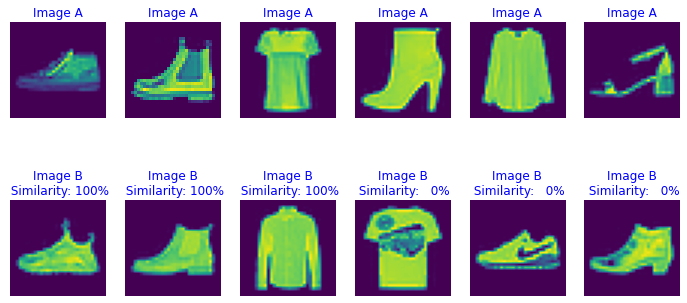

In [ ]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A', )
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')
plt.show()

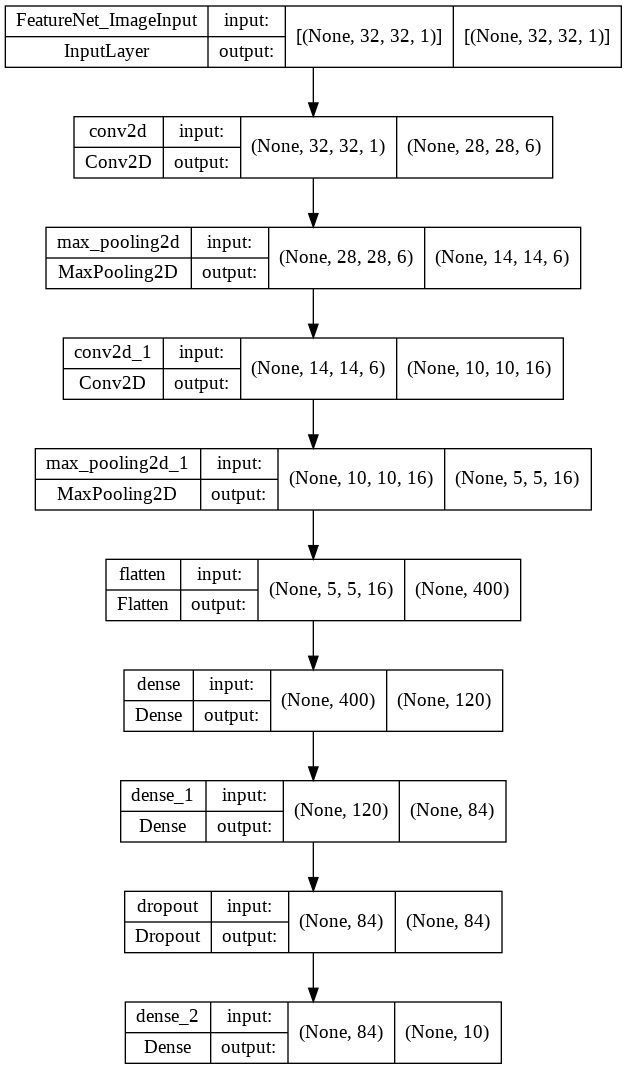

In [ ]:
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in

n_layer = Conv2D(filters=6, kernel_size=5, strides=1, activation='elu', input_shape=(32, 32, 1))(n_layer)
n_layer = MaxPool2D(pool_size=2, strides=2)(n_layer)
n_layer = Conv2D(filters=16, kernel_size=5, strides=1, activation='elu', input_shape=(14, 14, 6))(n_layer)
n_layer = MaxPool2D(pool_size=2, strides=2)(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(units=120, activation='elu')(n_layer)
n_layer = Dense(units=84, activation='elu')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = Dense(units=10, activation='softmax')(n_layer)

feature_model = Model(inputs = [img_in], outputs = [n_layer], name='FeatureGenerationModel')
tf.keras.utils.plot_model(feature_model, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.layers import concatenate

img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 FeatureGenerationModel (Functi  (None, 10)          61706       ['ImageA_Input[0][0]',           
 onal)                                                            'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['FeatureGeneratio

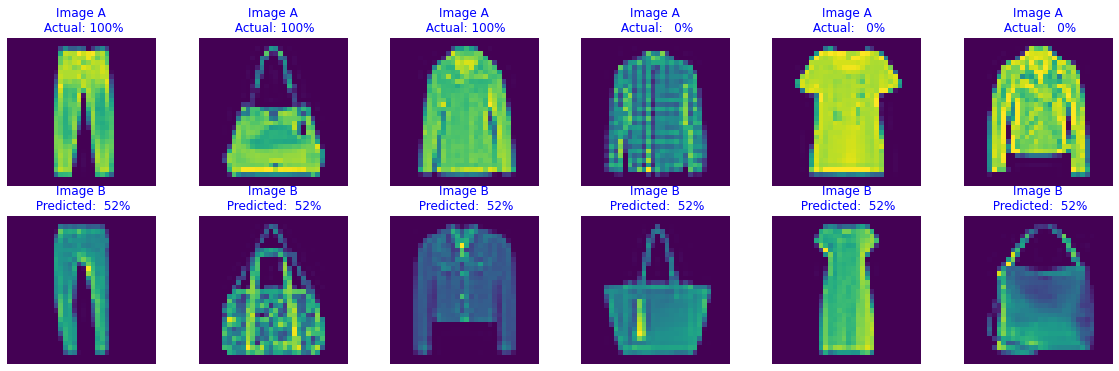

In [ ]:
def show_model_output(nb_examples = 3):
  pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
  pred_sim = similarity_model.predict([pv_a, pv_b])
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (20, 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,
    m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')
  plt.plot()

show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim


similarity_model.compile(optimizer='adamax', loss = 'binary_crossentropy', metrics = ['accuracy', 'mae'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-6,
)
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(siam_gen(train_groups),
    steps_per_epoch = 500,
    validation_data=([valid_a, valid_b],
    valid_sim),
    epochs = 40,
    verbose = True, 
    callbacks = [early_stop,reduce_lr]
  )

Epoch 1/40
500/500 [==============================] - 44s 84ms/step - loss: 0.5846 - accuracy: 0.6978 - mae: 0.4151 - val_loss: 0.5170 - val_accuracy: 0.7495 - val_mae: 0.3702 - lr: 0.0010
Epoch 2/40
500/500 [==============================] - 42s 85ms/step - loss: 0.5080 - accuracy: 0.7454 - mae: 0.3585 - val_loss: 0.4857 - val_accuracy: 0.7593 - val_mae: 0.3353 - lr: 0.0010
Epoch 3/40
500/500 [==============================] - 43s 86ms/step - loss: 0.4678 - accuracy: 0.7717 - mae: 0.3317 - val_loss: 0.4329 - val_accuracy: 0.7949 - val_mae: 0.3012 - lr: 0.0010
Epoch 4/40
500/500 [==============================] - 43s 86ms/step - loss: 0.4393 - accuracy: 0.7880 - mae: 0.3041 - val_loss: 0.4224 - val_accuracy: 0.7974 - val_mae: 0.2896 - lr: 0.0010
Epoch 5/40
500/500 [==============================] - 43s 86ms/step - loss: 0.4257 - accuracy: 0.7892 - mae: 0.2905 - val_loss: 0.4127 - val_accuracy: 0.7988 - val_mae: 0.2805 - lr: 0.0010
Epoch 6/40
500/500 [==============================] - 4

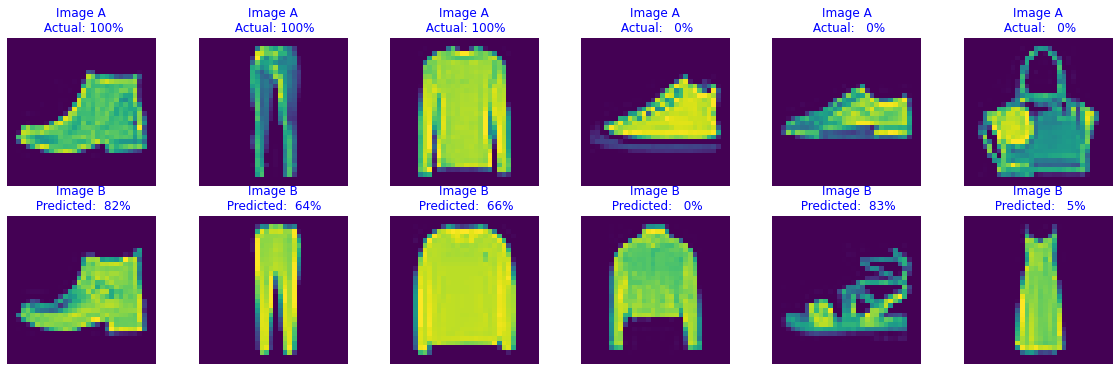

In [ ]:
show_model_output()

Text(0.5, 1.0, 'Pullover')

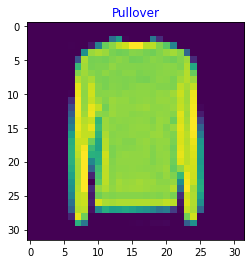

In [ ]:
from random import randint

obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

idx = randint(0, 59999)
image = x_train[idx]
plt.imshow(image[:, :, 0])
plt.title(obj_categories[y_train[idx]])

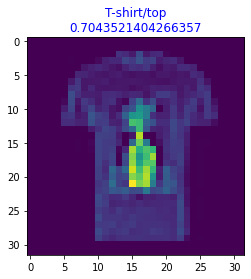

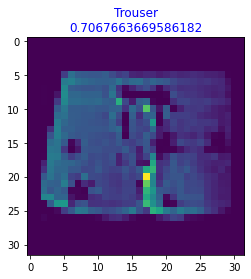

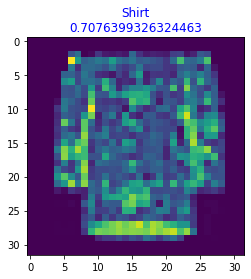

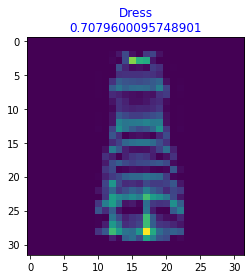

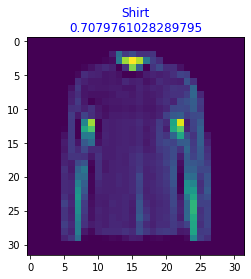

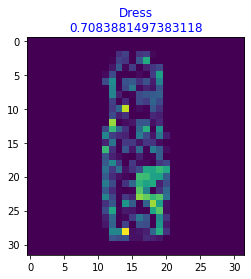

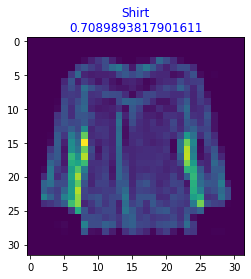

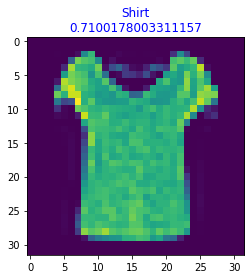

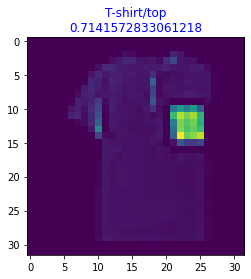

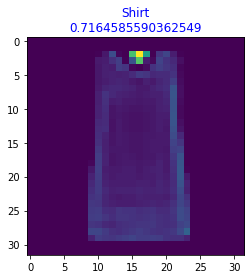

In [ ]:
def find_simmilar(dataset, labels, image, res_len):
    compiled = [np.tile(image, (len(dataset), 1, 1, 1)), np.stack(dataset)]
    preds = similarity_model.predict(compiled).reshape(-1)
    top = np.argpartition(preds, -res_len)[-res_len:]
    for i in top:
        plt.imshow(dataset[i][:, :, 0])
        plt.title(f'{obj_categories[labels[i]]}\n{preds[i]}')
        plt.show()


find_simmilar(x_test, y_test, image, 10)

In [ ]:
x_test_features = feature_model.predict(x_test, verbose = True,
batch_size=128)

79/79 [==============================] - 2s 24ms/step


In [ ]:
from sklearn.manifold import TSNE

tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=5000,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.015s...
[t-SNE] Computed neighbors for 10000 samples in 0.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000091
[t-SNE] Computed conditional probabilities in 0.829s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 78.4718475, gradient norm = 0.0080717 (50 iterations in 3.979s)
[t-SNE] Iteration 100: error = 70.4055405, gradient norm = 0.0043152 (50 iterations in 3.772s)
[t-SNE] Iteration 150: error = 67.3220520, gradient norm = 0.0028697 (50 iterations in 3.681s)
[t-SNE] Iteration 200: error = 65.6786575, gradient norm = 0.0021667 (50 iterations in 3.801s)
[t-SNE] Iteration 250: error = 64.5854950, gradient norm = 0.0017987 (50 iterations in 3.915s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.585495
[t-SNE] Iteration 300: error = 2.1550536, gradient norm = 0.0012792 (50 iterations in 3.973s)
[t-SNE] Iteration 350: error = 1.5959742, gradient norm = 0.0006340 (50 iterations in 4.049s)
[t-SNE] Iteration 400: error = 1.2940111, gradient norm = 0.0003845 (50 iterations in 4.002s)
[t-SNE] Iteration 450: error = 1.1153815, gradient norm = 0.0002633 (50 iterations in 4.009s)
[t-SNE] Iteration 500: error = 0.9994155, gradient norm = 0.0001940 (50 

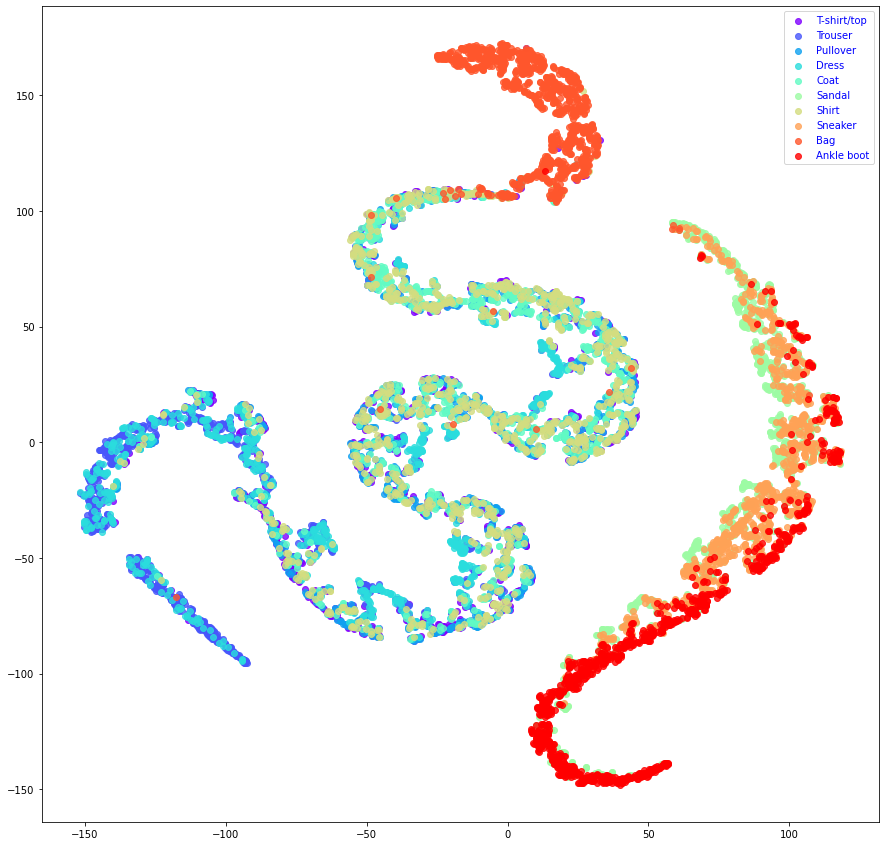

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(15, 15))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(tsne_features[np.where(y_test == c_group), 0],
  tsne_features[np.where(y_test == c_group), 1],
  marker='o',
  color=c_color,
  linewidth='1',
  alpha=0.8,
  label=c_label)
plt.legend()
plt.show(block=False)